# Why do we need Bayesian statistics? Part II -- The lighthouse problem (tutorial)

## Introduction

The lighthouse problem serves as a deceptively simple but captivating challenge in the field of statistics. As we shall explore, it subverts our conventional understandings of data and probability. Owing to its intriguing nature, this problem, introduced by [Gull](https://bayes.wustl.edu/sfg/why.pdf), is often featured in textbooks on Bayesian statistics, such as the one by [Sivia](https://global.oup.com/academic/product/data-analysis-9780198568322?cc=us&lang=en&). The problem is usually presented as


> Imagine a faulty lighthouse situated at an unknown coastal location, denoted by $l_x$​, and at a height $l_h$​ above sea level. While the lighthouse emits flashes at random angles, you can only observe the points where the light strikes the coast, without directly seeing the lighthouse itself. Given a series of such observations, how can you determine the lighthouse's location?

First, let’s clarify the geometry of the situation. We introduce the angle, denoted as $\theta$, between the lighthouse and the lightbeam, and the position where the lightbeam makes contact with the shore, referred to as $x$. All the relevant variables are depicted in the figure below.

<figure>
  <img src="https://github.com/PessoaP/blog/blob/master/Lighthouse/TikZfig-12.png?raw=true" alt="Lighthouse"/>
</figure>


The goal is, then, to use observations of $x$ to infer (or learn) the values of $l_x$ and $l_h$. In simpler terms, can we determine the location of the lighthouse by observing where the lightbeam is seen on the shore? For the present blog post we will assume that the height $l_h$ is already known, this is because for now we want to avoid the difficulties related to learn multiple parameters, but I will show how it is possible to learn $l_x$ and $l_h$ together in a following blog post (stay tuned).


While this blog post can be read independently, it builds upon the Bayesian language introduced in my previous [blog post](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/). 
To explain how we can infer $l_x$ from $x$, let's first delve into how synthetic data following this model would be generated. We will then use data visualization to gain insights regarding $l_x$. During this exploration, we will discover that the naive method, which involves calculating the mean and standard deviation, falls short. With this understanding, we will construct a Bayesian model and observe that it indeed leads to accurate inference on the lighthouse's position. This example highlights the necessity of data science approaches grounded in a rigorous understanding of probabilities.

## Generating (synthetic) data

First, let us decode what the question encodes with "the lighthouse emits flashes at random angles", this means that $\theta$ is uniformly distributed acute angle, that is $p(\theta) = \frac{1}{\pi}$ for $-\frac{\pi}{2}\leq\theta\leq \frac{\pi}{2}$. An obtuse angle would mean that the lightbeam does not hit the coastline. By looking back at the figure above trigonometry lead us to obtaing the lightbeam hit position $x$ in terms of the angle as
$$ tan \theta = \frac{x-l_x}{l_h} \Rightarrow x = l_x + l_h tan \theta \ .  \quad \quad \quad (1) $$

First, let us simulate the results of such experiment or, in other words, generate synthetic data. Here, for the sake of the argument let us assume that the lighthouse is located at the position origin, $l_x = 0$ and has unit height $l_h=1$. Generate synthetic data consists of sampling the random $\theta$ and calculating $x$ through the formula above.  The complete code, as well as this post in ipython notebook format is available in my [GitHub](https://github.com/PessoaP/blog/blob/master/Lighthouse/Lighthouse.ipynb) 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(42)

l_x,l_h = 0,1 #setting ground truth

th = np.pi*(np.random.rand(100000)-1/2) #sample theta
x = l_x +l_h*np.tan(th)

Before moving on with inference, let us try to visualize the data directly. One straightforward idea would be to simply create the histogram of the data. However a first attempt using the usual tools yields an awkward result.

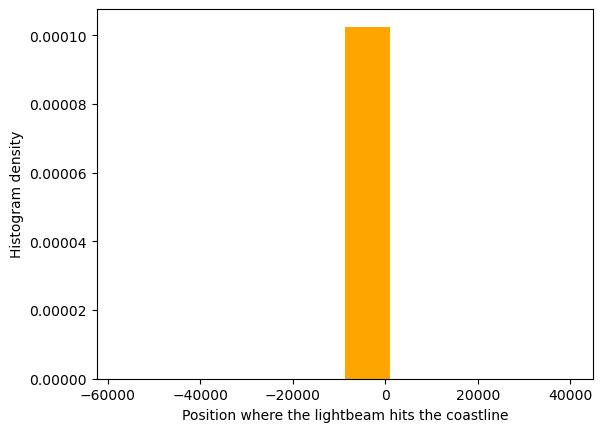

In [2]:
#Removed data block, see notebook for full code
plt.hist(x,density=True,color='orange')
plt.xlabel('Position where the lightbeam hits the coastline')
plt.ylabel('Histogram density')
plt.show()

The reason for this rather uninformative result comes from the fact that the dataset includes some rare but extremely large values. Let us observe this by visualizing the data in two different formats: *firstly* let us recreate the histogram but only for values within some region (chosen arbitrarily as [-50,50]), which will create a more reasonable histogram; and *second,* lets create a data scattered plot so that we can directly observe the rare deviant datapoints.

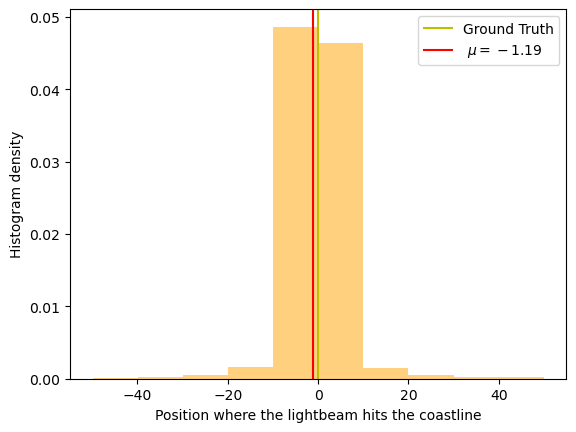

In [3]:
#Removed data block, see notebook on GitHub for full code
plt.hist(x[np.abs(x)<50],density=True,color='orange',alpha=.5)
plt.axvline(l_x,color='y',label='Ground Truth')
plt.axvline(x.mean(),color='r',label=r' $\mu = {:.2f}$'.format(x.mean()))
plt.xlabel('Position where the lightbeam hits the coastline')
plt.ylabel('Histogram density')
plt.legend()
plt.show()

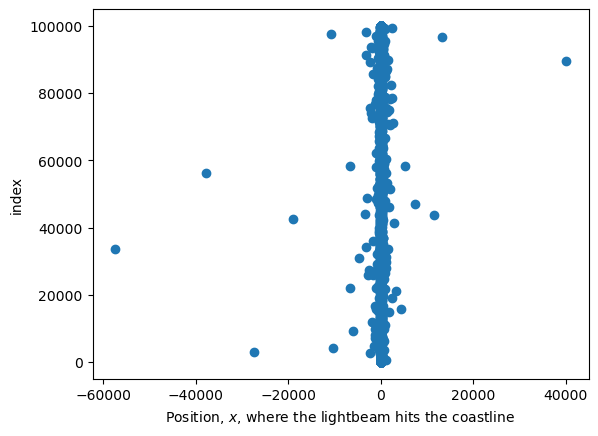

In [4]:
#Removed data block, see notebook on GitHub for full code
plt.scatter(x,np.arange(x.size))
plt.xlabel('Position, $x$, where the lightbeam hits the coastline')
plt.ylabel('index')
plt.show()

As these plots were generated with synthetic data, it's important to emphasize that the rare instances of values that significantly deviate from the mean should not be considered as 'outliers' in the traditional sense, nor should they be attributed to modeling innacuracy or experimental error. Instead, these extreme values are a direct outcome of the inherent characteristics of the problem being studied. If we go back to Eq (1) we see that $x$ will get arbitrarely large as $\theta$ approaches $\pi/2$. 

Now, considering the difficulties regarding data visualization alone, one may think that using the data visualized above to infer the lighthouse's position will be a challenging task. In order to show this, we will use the *opposite* strategy from my [previous blog post](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/). Here we begin by using the naive ''mean and standard deviation'' route, which will produce unsound results. Later, I will show how an approach based on correctly calculating the likelihood and, by extension, the Bayesian posterior lead to appropriate results.

## Mean and standard deviation

As one looks into the lighthouse image, they may think that the mean value of $x$ should correspond to the position $l_x$ of the lighthouse, if enough data points are drawn. If someone with more mathematical familiarity looks into Eq. (1), they might see that the probability of $\theta$ is symmetric around $0$ --- meaning the probability for $\theta$ is equal to the probability of $-\theta$. Therefore it must follow that that the $x$ should be symmetric around $l_x$ --- the probability of $l_x + {x'}$ should be equal to the probability of $l_x - {x'}$ for any ${x'}$. 

Now confident in the convergence of the mean to $l_x$, one could further argue that the actual value of $l_x$ should fall within the interval $[\mu - \sigma, \mu + \sigma]$, where $\mu$ represents the mean (or average) of $x$, and $\sigma$ denotes the standard deviation of $x$ divided by the square root of the number of data points [see discussion in the previous post](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/).

One can observe, however, what happens when we try to visualize this interval (the complete code,as well as this post in ipython notebook format is available in my [GitHub](https://github.com/PessoaP/blog/blob/master/Lighthouse/Lighthouse.ipynb) )

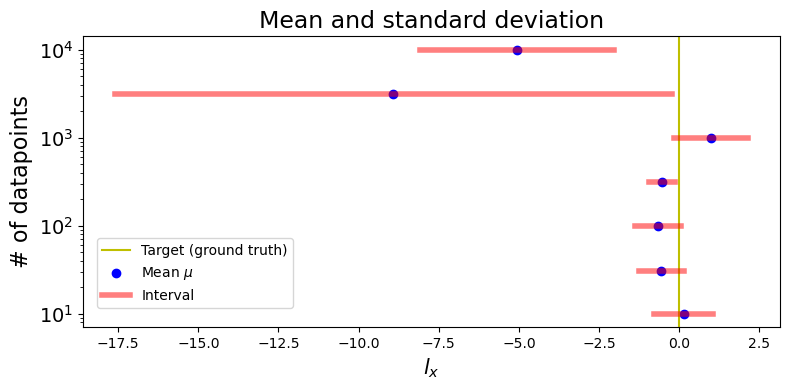

In [5]:
#Removed data block, see notebook on GitHub for full code

fig,ax =plt.subplots(1,figsize=(8,4))
n = [10,31,100,316,1000,3162,10000]
ax.axvline(0,color = 'y',label='Target (ground truth)')

label =True
for lim in n:
    mean = x[:lim].mean()
    sig = x[:lim].std()/np.sqrt(lim)
    confMS = (mean-sig,mean+sig)
    ax.scatter(mean,lim,color='b',label='Mean $\mu$')
    ax.plot(confMS,lim*np.ones(2),lw=4,color='r',alpha=.5,label='Interval')

    if label:
        fig.legend(loc=8,bbox_to_anchor=(.25,.2))
        label=False

ax.set_title('Mean and standard deviation',fontsize=17)
ax.set_yscale('log') 
ax.set_ylabel('# of datapoints',fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel(r'$l_x$',fontsize=15)
fig.tight_layout()

It becomes evident that, as the number of data points increase, the mean estimate of $l_x$ *does not converge towards the ground truth value*. Furthermore, the ''confidence interval'', determined by the mean and standard deviation, does not narrow as we increase the number of datapoints. This observation suggests that the mean and standard deviation alone are *insufficient to infer the lighthouse's position*.

## Bayesian 

Having established, in pratical terms, that the somewhat naive approach of mean and standard deviation fails in finding the position of the lighthouse, let us actually study the problem based on the Bayesian paradigm.

### Cauchy distribution
Following the Bayesian language [as defined in the previous post](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/), we ought obtain the likelihood of a data point $x$. In the paragraph where Eq. (1) is introduced, we discuss the uniform probability distribution for the angle $\theta$, and obtain $x$ in terms of $\theta$, $l_x$, and $l_h$. We can transform the probabilities for $\theta$ into probabilities for $x$ as 
$$p(x) = p(\theta) \left|\frac{\mathrm{d} \theta}{\mathrm{d} x}\right| . \quad \quad \quad (2) $$
[Read this for more detail on how the equation above is derived](https://en.wikibooks.org/wiki/Probability/Transformation_of_Probability_Densities). 

Now, after differentiating Eq. (1) and performing some algebra, you obtain the conditional probability density for $x$ given $l_x$​ and $l_h$​ as
$$p(x|l_x,l_h) = \frac{1}{\pi} \frac{l_h}{ (x-l_x)^2 + l_h^2 }  \ . \quad \quad \quad (3)  $$
This expression represents the probability density of observing a particular value $x$ when you have knowledge of the parameters $l_x$​ and $l_h$. Later we will use Bayes theorem to obtain the probability of $l_x$ given the observations (and in a future blog post we wil obtain the probabilities of both $l_x$ and $l_h$).

The probability distribution in Eq. (3) is also known as the [Cauchy distribution](https://mathworld.wolfram.com/CauchyDistribution.html). 
We observe that the probability of $x$ has a maximum at $x=l_x$, and it is symmetric around $l_x$. This observation adds an intriguing layer of complexity, as one might expect the mean of $x$ to converge to $l_x$ which, surprisingly, it does not.

In what follows, we procced into using Bayesian inference to address the lighthouse problem. However, it is worth noting that the perplexing behavior of the mean and standard deviation intervals can be attributed to certain unique properties of the Cauchy distribution. I will elaborate on these properties in a future blog post.

###  Likelihood



When we obtain data, in the form of a set of $N$ observations of the light,  $\{x_n\} = \{x_1, x_2,x_3, \ldots , x_N\}$ that are [independent and identically distributed](https://en.wikipedia.org/wiki/Independence_(probability_theory)), meaning each data point is generate without correlation to the previous ones, and all are drawn from the same lighthouse position. As such, the likehood for this data is given by multiplying Eq. (3) for every data pont $x_n$ thus yielding 
$$p(\{x_n\}|l_x) = \prod_{n=1}^N \left[ \frac{1}{\pi} \frac{l_h}{ (x_n-l_x)^2 + l_h^2 }  \right]  \ . \quad \quad \quad (4)  $$
Above and for the remainder of this post, the explicit dependance in $l_h$ is ignored, as we assume its value is already known, in a future blog post we will study how the problem changes when one tries to infer both $l_x$ and $l_h$.


Since each value within the product in Eq. (4) is small, and multiplying a large batch of small numbers can be approximated to zero by the computer, it's a useful technique in inference to calculate the logarithm of the likelihood instead
$$\ln p(\{x_n\}|l_x) = \sum_{n=1}^N \ln \left[ \frac{1}{\pi} \frac{l_h}{ (x_n-l_x)^2 + l_h^2 }  \right] =  \sum_{n=1}^N \left[ \ln (l_h) - \ln(\pi) -  \ln ({ (x_n-l_x)^2 + l_h^2 } ) \right] \ . \quad \quad \quad (5)  $$
This is calculated through the following block of code:

In [6]:
def log_like(x,lx,lh):
    X,LX=np.meshgrid(x,lx) 
    den = (X-LX)**2+lh**2
    return np.sum(np.log(lh)-np.log(np.pi)-np.log(den),axis=1)

The use of `np.meshgrid` and `np.sum` above are methods to avoid the overuse of `for` loops or, in other words, to [vectorize](https://www.askpython.com/python-modules/numpy/vectorization-numpy) the code.

### Prior

Following the Bayesian framework [outlined in the previous post](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/), we aim to incorporate prior information into our inference process. In this context, we want to choose a prior that is as uniform as possible to avoid introducing bias into our Bayesian inference. A uniform prior essentially means that we have as little prior information or preference as possible, allowing the data to have the most significant influence on our final inference. This approach is often referred to as non-informative or uninformative prior, as it doesn't favor any particular parameter value and lets the data speak for itself. Here we will assume a prior of the form
$$
p(l_x) = \lim_{L\rightarrow \infty}
\begin{cases}
\frac{1}{L} & \text{for} \  -\frac{L}{2}<l_x<\frac{L}{2} \\
0 & \text{otherwise}
\end{cases} \ .  \quad \quad \quad (6)
$$
Or, in other words, the prior is uniform in the interval $(-\frac{L}{2},\frac{L}{2})$ and take the limit $L \rightarrow \infty$.

### Posterior

From the [previous discussion](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/), we obtain the posterior using the Bayes' theorem:
$$p(l_x|\{x_n\}) = \frac{ p(\{x_n\}|l_x)}{p(\{x_n\})}    p(l_x)  \ , \quad \quad \quad (7)$$  
with the evidence, $p(x)$, being a proportionality constant that does not depend on $l_x$ will be referred to as $Z$. By substituting Eqs. (5) and (6) and taking the logarithm above we obtain
$$\ln p(l_x|\{x_n\}) = \ln { p(\{x_n\}|l_x)}  - \ln{(LZ)} \ , \quad \quad \quad (8)$$  
thus leading to a posterior of the form
$$ p(l_x|\{x_n\}) = \frac{1}{Z'} \ \exp\left[ \ln { p(\{x_n\}|l_x)}  \right]  \ , \quad \quad \quad (9)$$  
where $Z' = ZL$, which does not depend on $l_x$ and is numerically calculated by ensuring that the posterior is a probability distribution, *i.e.*, $\int \mathrm{d}  l_x  \ p(l_x|\{x_n\}) = 1$. 
The following block of code gives a function to calculate the posterior with the appropriate normalization.

In [7]:
def posterior_x(data,precision=.001):
    lx = np.linspace(-10,10,int(1/precision)+1)
    dlx = lx[1]-lx[0]
    
    #non-marginalized posterior
    l = log_like(data,lx,l_h)
    l -= l.max()
    posterior = np.exp(l) 

    #Calculating Z' numerically
    Zprime = np.sum(posterior)*dlx

    #marginalized
    posterior = posterior/Zprime
    return lx, posterior


The posterior in Eq. (9) provides us with all the necessary tools for conducting Bayesian inference for the lighthouse problem. As an initial step to visualize the posterior, let's juxtapose a graph of the posterior with a density histogram, both obtained using only the first 100 data points $x_n$ we generated.

The data mean is -0.6674364059676746, while the posterior maximum is -0.09999999999999964


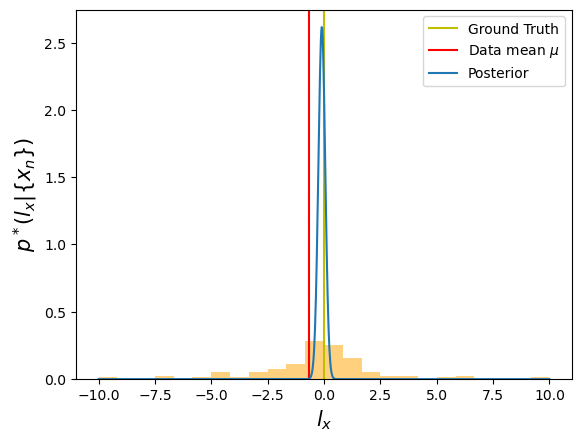

In [8]:
#Removed data block, see notebook on GitHub for full code

x_eff = x[:100]
plt.hist(x_eff,density=True,bins=np.linspace(-10,10,25),color='orange',alpha=.5)


lx_arr,p = posterior_x(x[:100])
print('The data mean is {}, while the posterior maximum is {}'.format(x_eff.mean(), lx_arr[p.argmax()]))

plt.axvline(l_x,color='y',label='Ground Truth')
plt.axvline(x_eff.mean(),color='r',label=r'Data mean $\mu$')

plt.ylabel('$p^*(l_x|\{x_n\})$',fontsize=15)
plt.xlabel(r'$l_x$',fontsize=15)

plt.plot(lx_arr,p,label='Posterior')
plt.legend()
plt.savefig('output_32_1.png',dpi=200)
plt.show()




The figure above reveals two intriguing observations. Firstly, the posterior for $l_x$ exhibits a qualitatively distinct behavior compared to the histogram of $x$, displaying a significantly narrower distribution. Secondly, and perhaps more importantly, the posterior's maximum value $( \arg \max\limits_{l_x} p(l_x|{x_n}) \approx -.1 )$ is remarkably closer to the true ground value of $(0)$ when compared to the data mean $(\mu \approx -0.67)$. This serves as a compelling example of how a rigorous study of probabilities translates into more precise inferences regarding the lighthouse's position, $l_x$.


## Credible intervals

Following the procedure outlined in the
[previous blog post](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/), we move into calculating the Bayesian credible interval from the posterior. As in the previous post we ought to find the smallest symmetric interval around the posterior maximum (or mode) such that the probability that $l_x$ is within that interval is larger than $95\%$. The code for finding it is outlined below.

In [9]:
def credible_interval(data,conf=.95,precision=.001): 
    q,post = posterior_x(data,precision)
    dq = q[1]-q[0]
    max_ind = post.argmax() #find the index for the posterior maximum
    dif = 1 
    while np.sum(post[max_ind-dif:max_ind+dif+1])*dq<conf: #increase the interval until finding the desired credible interval
        dif+=1
    if dif==1:
        return credible_interval(data,conf=.95,precision=.001/4)
    return q[max_ind-dif],q[max_ind+dif]

With this, we can graph the credible interval as a function of the number of datapoints, similarly to our previous plots of the mean and standard deviation intervals. For comparison, we plot the mean and standard deviation intervals once again. Our goal here is to see how the credible interval changes with the size of the dataset. We will obtain the interval generated by both methods with the same dataset of $N^\ast$ datapoints (the $N^\ast$ first $x_n$ generated), with $N^\ast$ varying from $10$ to $10^4$.

While the block of code below is large, it is not more than code needed to make a graph in Python, the reader can go straight to the final result.

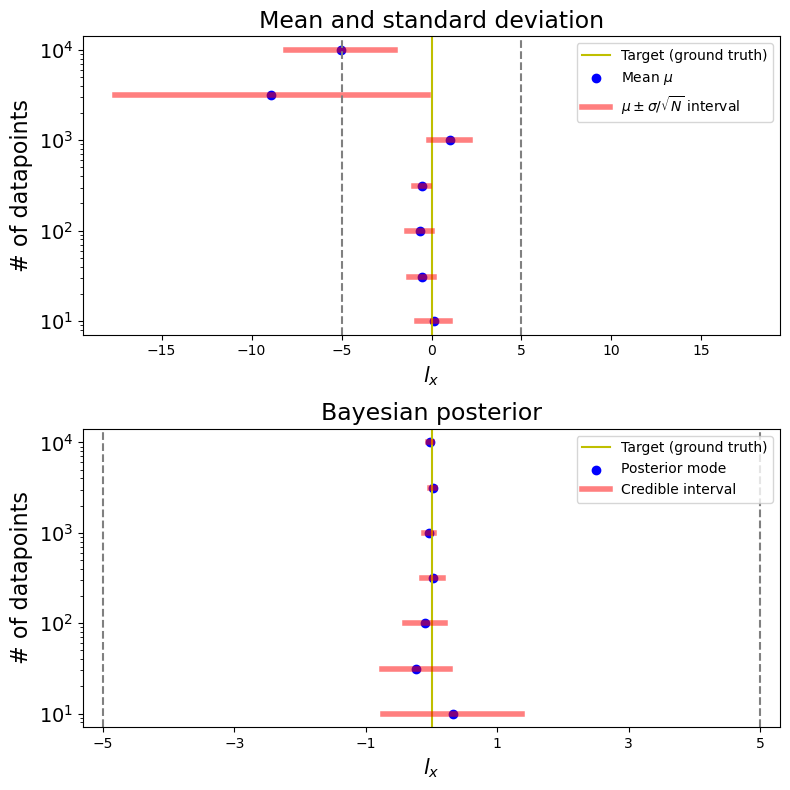

In [10]:
#Removed data block, see notebook on GitHub for full code

fig,(ax1,ax2) =plt.subplots(2,figsize=(8,8))
n = [10,31,100,316,1000,3162,10000]
ax1.axvline(0,color = 'y',label='Target (ground truth)')

width = 0
label =True
for lim in n:
    mean = x[:lim].mean()
    sig = x[:lim].std()/np.sqrt(lim)
    confMS = (mean-sig,mean+sig)
    width = np.max((width,np.max(np.abs(confMS))))
    ax1.scatter(mean,lim,color='b',label='Mean $\mu$')
    ax1.plot(confMS,lim*np.ones(2),lw=4,color='r',alpha=.5,label='$\mu \pm {\sigma}/{\sqrt{N}} $ interval')

    if label:
        ax1.legend()
        label=False

ax1.set_xlim(width*1.1*np.array((-1,1)))
ax1.set_title('Mean and standard deviation',fontsize=17)
ax1.set_yscale('log') 
ax1.set_ylabel('# of datapoints',fontsize=16)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel(r'$l_x$',fontsize=15)
#fig.tight_layout()

ax2.axvline(0,color = 'y',label='Target (ground truth)')
label =True
for lim in n[::-1]:
    conf = credible_interval(x[:lim])
    mode = np.mean(conf) #recovers the center of the credible interval
    ax2.scatter(mode,lim,color='b',label = 'Posterior mode')
    ax2.plot(conf,lim*np.ones(2),lw=4,color='r',alpha=.5,label='Credible interval')

    if label:
        ax2.legend()
        label=False

ax2.set_xlim(-5.3,5.3)
ax2.set_xticks(np.arange(-5,6,2))
ax2.set_title('Bayesian posterior',fontsize=17)
ax2.set_yscale('log') 
ax2.set_ylabel('# of datapoints',fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel(r'$l_x$',fontsize=15)

[[ax.axvline(s*5, color='gray', linestyle='--') for ax in (ax1,ax2)] for s in (-1,1)]
fig.tight_layout()
plt.savefig('lighthouse.png',dpi=100)

Here, we observe that the Bayesian credible interval is significantly more accurate than the one obtained naively through the mean and standard deviation. This holds true even for a small number of data points (note that the range in the bottom figure is significantly narrower when compared to the top one, the grey dashed line correspond to the same values in both graphs). The accuracy of using Bayesian becomes even more impresive when we notice that, while the mean and standard deviation interval *should* [correspond to the 63.8\% credible interval](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/), the second graph presents the 95% credible intervals. This reinforces the importance of embracing a more comprehensive understanding of probability, as straightforward (yet somewhat naive) statistical methods can easily lead to misleading results.


## Conclusion

Through the simple example of the lighthouse problem, this blog post has provided insights into the complexities of statistical analysis. It has underscored the limitations of relying solely on mean and standard deviation, particularly when confronted with distributions such as the Cauchy distribution that deviate from the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). While we have briefly discussed some of the underlying reasons for this unconventional behavior, a more comprehensive examination of the Cauchy distribution will be the topic of a forthcoming blog post.

Furthermore, we have introduced the prospect of inferring both the lighthouse's position, designated as $l_x$, and its height, $l_h$, based on lightbeam observations, $x$. This converts a one-dimensional dataset (in which all $x$ values are single valued) into a two-dimensional posterior distribution, expressed as $p(l_x, l_h | x)$. A comprehensive tutorial for this more complex problem will be the topic of another future blog post.

I invite readers to remain engaged and follow for the forthcoming publications, where we will delve further into these nuanced aspects of probability and statistical analysis. 